# Voter classification with exit poll data


In this notebook, we will explore the problem of voter classification.

Given demographic data about a voter and their opinions on certain key issues, can we predict their vote in the 2016 U.S. presidential election? We will attempt this using a $k$ nearest neighbor classifier.

## Import libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import nan_euclidean_distances

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We will need to install a library that is not in the default Colab environment:

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.2MB/s 


In [ ]:
import category_encoders as ce

## Load data


The data for this notebook comes from the [U.S. National Election Exit Day Polls](https://ropercenter.cornell.edu/exit-polls/us-national-election-day-exit-polls). 

To get the data into Colab, click the file icon on the left side of the Colab workspace, then the upload icon. Upload the CSV file (`31116396_National2016.csv`) to your Colab workspace.


In [ ]:
df = pd.read_csv('31116396_National2016.csv')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
0,135355,Hillary Clinton,The Democratic candidate,6.530935,,18-29,18-29,18-24,18-44,18-49,18-29,18-24,Non-Black 18-29,Latino 18-29,Latino 18-29,,,,Complete,,,,,,,30,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Hispanic/Latino,West,,,,,Female,Latino women,Married women,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In October,In the last month,Before that,,,,,,,,,Version 1,,,No,,,
1,135356,Hillary Clinton,The Democratic candidate,6.479016,,18-29,18-29,25-29,18-44,18-49,18-29,25-29,Non-Black 18-29,Latino 18-29,Latino 18-29,,,,Complete,,,,,,,44,,,,,,,,,,,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Hispanic/Latino,West,,,,,Male,Latino men,Married men,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In October,In the last month,Before that,,,,,,,,,Version 1,,,No,,,
2,135357,Hillary Clinton,The Democratic candidate,8.493230,,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,,,,Complete,,,,,,,6,,,,,,,,,,,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Asian,West,,,,,Male,All other races,Married men,"Cities 50,000-500,000","Cities over 50,000",English,,California,Other,,,Telephone survey,,,,In September,Before that,Before that,,,,,,,,,Version 1,,,No,,,
3,135358,Hillary Clinton,The Democratic candidate,3.761814,,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,,,,Complete,,,,,,,11,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Other,West,,,,,Female,All other races,Non married women,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In the last week,In the last month,In the last week,,,,,,,,,Version 1,,,No,,,
4,135359,Hillary Clinton,The Democratic candidate,3.470473,,45-65,30-59,45-49,45+,18-49,45-59,40-49,Black 45-59,Black 45-59,Black 45-64,,,,Complete,,,,,,,37,,,,,,,,,,,Postgraduate study,College graduate,More than High school graduate,Non white college degree,...,Non-white,Black,West,,,,,Female,Black women,Non married women,"Cities over 500,000","Cities over 50,000",English,,California,Other,,,Telephone survey,,,,Before that,Before that,Before that,,,,,,,,,Version 1,,,No,,,


In [ ]:
df.shape

(25034, 138)

## Prepare data

In [ ]:
df.replace(" ", float("NaN"), inplace=True)

Encode target variable as a binary variable:

In [ ]:
df = df[df['PRES'].isin(['Donald Trump', 'Hillary Clinton'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22798 entries, 0 to 25033
Columns: 138 entries, ID to WPROTBRN3
dtypes: float64(1), int64(2), object(135)
memory usage: 24.2+ MB


In [ ]:
y = df['PRES'].map({'Donald Trump': 1, 'Hillary Clinton': 0}) 
y.value_counts()

0    12126
1    10672
Name: PRES, dtype: int64

In [ ]:
df.shape

(22798, 138)

## Add features to your classifier

For this assignment, we try to improve the performance of the classifier by adding additional features, such as:

* More demographic information: `INCOME16GEN`, `MARRIED`, `RELIGN10`, `ATTEND16`, `LGBT`, `VETVOTER`
* Opinions about political issues and about what factors are most important in determining which candidate to vote for: `TRACK`, `SUPREME16`,  `FINSIT`, `IMMWALL`, `ISIS16`, `LIFE`, `TRADE16`, `HEALTHCARE16`, `GOVTDO10`, `GOVTANGR16`, `QLT16`, `ISSUE16`, `NEC`


(We will not use questions that directly ask the participants how they feel about individual candidates, or about their party affiliation or political leaning.)

The basic requirement is to add:

* four features that are encoded using ordinal encoding, and 
* four features that are encoded using one-hot encoding.

In [ ]:
features = ['EDUC12R', 'AGE', 'RACE', 'INCOME16GEN', 'MARRIED', 'RELIGN10', 'ATTEND16', 'LGBT', 'VETVOTER', 
            'TRACK', 'SUPREME16',  'FINSIT', 'IMMWALL', 'ISIS16', 'LIFE', 
            'TRADE16', 'HEALTHCARE16', 'GOVTDO10', 'GOVTANGR16', 'QLT16', 
            'ISSUE16', 'NEC']

In my solution, I will add more than four of each - but that's not required.

## Encode ordinal features

The following features should be encoded using ordinal encoding. They should not be encoded with one-hot encoding, since there is a logical sequence to the potential values in each feature. Using ordinal encoding preserves this sequence for the distance computation.

The mapping for each feature should reflect the logical order of the possible values.

In [ ]:
mapping_dict = {'col': 'AGE', 'mapping': 
                {'18-29': 1, 
                 '30-44': 2,
                 '45-65': 3,
                 '65+': 4}
                }, {'col': 'EDUC12R', 'mapping':  
                  {'High school or less': 1,
                   'Some college/assoc. degree': 2,
                   'College graduate': 3,
                   'Postgraduate study': 4}
                    }, {'col': 'INCOME16GEN', 'mapping':  
                  {'Under $30,000': 1,
                   '$30,000-$49,999': 2,
                   '$50,000-$99,999': 3,
                   '$100,000-$199,999': 4,
                   '$200.000-$249,999': 5,
                   '$250,000 or more': 6}                  
                    }, {'col': 'GOVTANGR16', 'mapping':  
                  {'Angry': 1,
                   'Dissatisfied, but not angry': 2,
                   'Satisfied, but not enthusiastic': 3,
                   'Enthusiastic': 4,
                   'Omit': -1}
                    }, {'col': 'ATTEND16', 'mapping':  
                  {'Never': 1,
                   'A few times a year': 2,
                   'A few times a month': 3,
                   'Once a week or more': 4}
                    }, {'col': 'SUPREME16', 'mapping':  
                  {'Not a factor at all': 1,
                   'A minor factor': 2,
                   'An important factor': 3,
                   'The most important factor': 4,
                   'Omit': -1}
                    }, {'col': 'ISIS16', 'mapping':  
                  {'Very badly': 1,
                   'Somewhat badly': 2,
                   'Somewhat well': 3,
                   'Very well': 4,
                   'Omit': -1}
                    }, {'col': 'LIFE', 'mapping':  
                  {'Worse than life today': 1,
                   'About the same': 2,
                   'Better than life today': 3,
                   'Omit': -1}
                    }, {'col': 'NEC', 'mapping':  
                  {'Excellent': 1,
                   'Good': 2,
                   'Not so good': 3,
                   'Poor': 4,
                   'Omit': -1}
                    }, {'col': 'HEALTHCARE16', 'mapping':  
                  {'Went too far': 1,
                   'Was about right': 2,
                   'Did not go far enough': 3,
                   'Omit': -1}
                    }, {'col': 'FINSIT', 'mapping':  
                  {'Worse today': 1,
                   'About the same': 2,
                   'Better today': 3,
                   'Omit': -1}
                    }, {'col': 'TRADE16', 'mapping':  
                  {'Takes away U.S. jobs': 1,
                   'Has no effect on U.S. jobs': 2,
                   'Creates more U.S. jobs': 3,
                   'Omit': -1}
                    }

In [ ]:
features_ord = ['EDUC12R', 'AGE', 'INCOME16GEN', 'ATTEND16', 'SUPREME16', 'ISIS16', 'LIFE', 'GOVTANGR16', 'NEC', 'HEALTHCARE16', 'FINSIT', 'TRADE16']

enc_ord = ce.OrdinalEncoder(handle_missing='return_nan', mapping=mapping_dict)
enc_ord.fit(df[features_ord])

df_v2_ord = enc_ord.transform(df[features_ord])

In [ ]:
df_v2_ord.replace(-1, float("NaN"), inplace=True)

for col in df_v2_ord.columns:
  df_v2_ord[col] = df_v2_ord[col]-df_v2_ord[col].min(skipna=True)
  df_v2_ord[col] = df_v2_ord[col]/df_v2_ord[col].max(skipna=True)

In [ ]:
df_v2_ord.describe()

,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16
count,21798.000000,22640.000000,8437.000000,4230.000000,4338.000000,4170.000000,4360.000000,4553.000000,4448.000000,4240.000000,4307.000000,4228.000000
mean,0.502202,0.542609,0.396302,0.538455,0.601352,0.424620,0.552867,0.394392,0.593825,0.429953,0.530532,0.485691
std,0.329376,0.323963,0.266629,0.385464,0.313631,0.305561,0.426003,0.284469,0.265140,0.442013,0.386649,0.471166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.200000,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000
50%,0.333333,0.666667,0.400000,0.333333,0.666667,0.333333,0.500000,0.333333,0.666667,0.500000,0.500000,0.500000
75%,0.666667,0.666667,0.600000,1.000000,0.666667,0.666667,1.000000,0.666667,0.666667,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Encode binary features


Features with two possible values can be encoded either way, as ordinal features or using one-hot encoding. 



In [ ]:
features_bin = ['SEX', 'MARRIED', 'LGBT', 'TRACK', 'VETVOTER', 'IMMWALL', 'GOVTDO10']

Here is how you could encode them using ordinal encoding:

In [ ]:
mapping_dict = {'col': 'SEX', 'mapping': 
                {'Female': 1, 
                 'Male': 2,
                 'Omit': -1}
                },{'col': 'MARRIED', 'mapping': 
                {'No': 1, 
                 'Yes': 2,
                 'Omit': -1}
                },{'col': 'LGBT', 'mapping': 
                {'No': 1, 
                 'Yes': 2,
                 'Omit': -1}
                },{'col': 'TRACK', 'mapping': 
                {'Seriously off on the wrong track': 1, 
                 'Generally going in the right direction': 2,
                 'Omit': -1}
                },{'col': 'VETVOTER', 'mapping': 
                {'No': 1, 
                 'Yes': 2,
                 'Omit': -1}
                },{'col': 'IMMWALL', 'mapping': 
                {'Oppose': 1, 
                 'Support': 2,
                 'Omit': -1}
                },{'col': 'GOVTDO10', 'mapping': 
                {'Government is doing too many things better left to businesses and individuals': 1, 
                 'Government should do more to solve problems': 2,
                 'Omit': -1}
                },

enc_bin = ce.OrdinalEncoder(handle_missing='return_nan', mapping=mapping_dict)
enc_bin.fit(df[features_bin])

df_v2_bin_ord = enc_bin.transform(df[features_bin])
df_v2_bin_ord.replace(-1, float("NaN"), inplace=True)


In [ ]:
for col in df_v2_bin_ord.columns:
  df_v2_bin_ord[col] = df_v2_bin_ord[col]-df_v2_bin_ord[col].min(skipna=True)
  df_v2_bin_ord[col] = df_v2_bin_ord[col]/df_v2_bin_ord[col].max(skipna=True)

In [ ]:
df_v2_bin_ord.describe()

,SEX,MARRIED,LGBT,TRACK,VETVOTER,IMMWALL,GOVTDO10
count,22749.000000,8793.000000,4201.000000,4163.000000,4235.000000,4185.000000,4208.000000
mean,0.445250,0.589332,0.046179,0.372087,0.132704,0.426523,0.494772
std,0.497004,0.491983,0.209899,0.483420,0.339294,0.494631,0.500032
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Here is how you could encode them using one-hot encoding.

In [ ]:
enc_bin = ce.OneHotEncoder(use_cat_names=True)
enc_bin.fit(df[features_bin])

df_v2_bin_oh = enc_bin.transform(df[features_bin])


df_v2_bin_oh.drop(['SEX_nan', 'MARRIED_nan', 'LGBT_nan', 'TRACK_nan', 'TRACK_Omit',
               'VETVOTER_nan', 'IMMWALL_nan', 'IMMWALL_Omit', 'GOVTDO10_nan', 'GOVTDO10_Omit'], axis=1, inplace=True)

In [ ]:
df_v2_bin_oh.columns

Index(['SEX_Female', 'SEX_Male', 'MARRIED_Yes', 'MARRIED_No', 'LGBT_No',
       'LGBT_Yes', 'TRACK_Seriously off on the wrong track',
       'TRACK_Generally going in the right direction', 'VETVOTER_No',
       'VETVOTER_Yes', 'IMMWALL_Oppose', 'IMMWALL_Support',
       'GOVTDO10_Government should do more to solve problems',
       'GOVTDO10_Government is doing too many things better left to businesses and individuals'],
      dtype='object')

In [ ]:
df_v2_bin_oh.describe()

,SEX_Female,SEX_Male,MARRIED_Yes,MARRIED_No,LGBT_No,LGBT_Yes,TRACK_Seriously off on the wrong track,TRACK_Generally going in the right direction,VETVOTER_No,VETVOTER_Yes,IMMWALL_Oppose,IMMWALL_Support,GOVTDO10_Government should do more to solve problems,GOVTDO10_Government is doing too many things better left to businesses and individuals
count,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000
mean,0.553557,0.444293,0.227301,0.158391,0.175761,0.008510,0.114659,0.067945,0.161111,0.024651,0.105272,0.078296,0.091324,0.093254
std,0.497134,0.496898,0.419098,0.365115,0.380625,0.091856,0.318617,0.251656,0.367641,0.155063,0.306911,0.268643,0.288075,0.290794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Encode categorical features



The following features should be encoded with one-hot encoding. Ordinal encoding of these features would imply an ordering that doesn't actually exist.

In [ ]:
features_oh =  ['RACE', 'ISSUE16', 'QLT16', 'RELIGN10']
enc_oh = ce.OneHotEncoder(use_cat_names=True)

enc_oh.fit(df[features_oh])

df_v2_oh = enc_oh.transform(df[features_oh])


df_v2_oh.drop(['RACE_nan', 'ISSUE16_nan', 'ISSUE16_Omit', 'QLT16_Omit', 
               'QLT16_nan', 'RELIGN10_nan'], axis=1, inplace=True)

In [ ]:
df_v2_oh.columns

Index(['RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black',
       'RACE_White', 'ISSUE16_Foreign policy', 'ISSUE16_The economy',
       'ISSUE16_Terrorism', 'ISSUE16_Immigration', 'QLT16_Has good judgment',
       'QLT16_Can bring needed change', 'QLT16_Has the right experience',
       'QLT16_Cares about people like me', 'RELIGN10_Protestant',
       'RELIGN10_None', 'RELIGN10_Other christian', 'RELIGN10_Catholic',
       'RELIGN10_Jewish', 'RELIGN10_Other', 'RELIGN10_Muslim',
       'RELIGN10_Mormon'],
      dtype='object')

In [ ]:
df_v2_oh.describe()

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon
count,22798.000000,22798.00000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000,22798.000000
mean,0.096938,0.03009,0.029871,0.131283,0.698219,0.048732,0.211948,0.072243,0.046101,0.074875,0.160540,0.088955,0.057198,0.078252,0.049873,0.087552,0.078603,0.008597,0.025309,0.003114,0.005000
std,0.295880,0.17084,0.170235,0.337717,0.459041,0.215313,0.408697,0.258896,0.209707,0.263195,0.367115,0.284685,0.232226,0.268574,0.217687,0.282648,0.269125,0.092324,0.157066,0.055720,0.070538
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split data into training and test sets

Next, split data into a training set and a test set, with 25% of the data reserved for the test set.

In [ ]:
df_combined = pd.concat([df_v2_ord, df_v2_bin_oh, df_v2_oh, pd.DataFrame(y)], axis=1)
df_combined.shape

(22798, 48)

In [ ]:
df_combined.shape

(22798, 48)

Since I plan to try a few different variations on the data - some with different types of encoding, some with only a subset of features - and I want to evaluate them all with the same train-test split, I'm going to just get the indices of the training and test sets. 

In [ ]:
idx_train, idx_test = train_test_split(np.arange(0, df_combined.shape[0]), test_size=0.25)

Then I can use these indices to get the training and test feature matrices and label vectors.

In [ ]:
X_train = df_combined.drop(['PRES'], axis=1).iloc[idx_train]
y_train = df_combined['PRES'].iloc[idx_train]

X_test = df_combined.drop(['PRES'], axis=1).iloc[idx_test]
y_test = df_combined['PRES'].iloc[idx_test]

In [ ]:
X_train.shape

(17098, 47)

In [ ]:
X_test.shape

(5700, 47)

## Train a $k$ nearest neighbors classifier

Now, we cam train a $k$ nearest neighbors classifier, using pre-computed distances with `nan_euclidean_distances`.


After we "train" our classifier, we evaluate its accuracy on the test set.

In [ ]:
distances_train = nan_euclidean_distances(np.array(X_train)) # distance between rows of X
distances_train.shape

(17098, 17098)

In [ ]:
distances_test = nan_euclidean_distances(np.array(X_test),np.array(X_train)) 
distances_test.shape

(5700, 17098)

Use K-fold CV to select k:

In [ ]:
from sklearn.model_selection import KFold

n_fold = 5
k_list = np.arange(1, 101, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

print(kf)

for isplit, idx in tqdm( enumerate(kf.split(X_train)), total=n_fold, desc="K-fold"):

  train_index, val_index = idx 
  y_train_kfold = np.array(y_train)[train_index]
  y_val_kfold = np.array(y_train)[val_index]

  for idx_k, k in enumerate(k_list):
    distances_train_kfold = distances_train[train_index[:, None], train_index]
    distances_val_kfold = distances_train[val_index[:, None], train_index]

    clf = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
    clf.fit(distances_train_kfold, y_train_kfold)

    y_pred = clf.predict(distances_val_kfold)
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

K-fold:   0%|          | 0/5 [00:00<?, ?it/s]

KFold(n_splits=5, random_state=None, shuffle=False)


K-fold: 100%|██████████| 5/5 [02:07<00:00, 25.51s/it]


In [ ]:
# delete these variables we don't need anymore, to free up memory
del(distances_train_kfold)
del(distances_val_kfold)

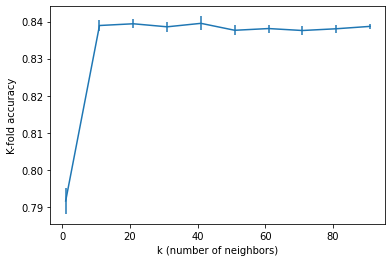

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Using this, we can select $k$ and then re-fit our model using this value.

In [ ]:
k_opt=k_list[np.argmax(acc_list.mean(axis=1))]
print(k_opt)

41


In [ ]:
clf = KNeighborsClassifier(n_neighbors=k_opt, metric='precomputed')
clf.fit(distances_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='precomputed',
                     metric_params=None, n_jobs=None, n_neighbors=41, p=2,
                     weights='uniform')

In [ ]:
y_pred = clf.predict(distances_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

0.8450877192982457

With ordinal encoding for the binary features, the accuracy may be somewhat lower:

In [ ]:
df_combined_ord = pd.concat([df_v2_ord, df_v2_bin_ord, df_v2_oh, pd.DataFrame(y)], axis=1)

In [ ]:
X_train = df_combined_ord.drop(['PRES'], axis=1).iloc[idx_train]
y_train = df_combined_ord['PRES'].iloc[idx_train]

X_test = df_combined_ord.drop(['PRES'], axis=1).iloc[idx_test]
y_test = df_combined_ord['PRES'].iloc[idx_test]


In [ ]:
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
distances_test = nan_euclidean_distances(np.array(X_test),np.array(X_train)) 

In [ ]:
distances_train = nan_euclidean_distances(np.array(X_train)) # distance between rows of X
 
clf = KNeighborsClassifier(n_neighbors=k_opt, metric='precomputed')
clf.fit(distances_train, y_train)
y_pred = clf.predict(distances_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

0.7740350877192983

For this assignment, there is no specific accuracy target you had to hit. But if you want to learn more about how to improve the accuracy of the model, continue to the "bonus" section!

## Bonus: Improve our $k$ nearest neighbor model


Is the $k$ nearest neighbor model good? It achieves an accuracy that is well above the accuracy of a classifier that always predicts the majority vote. 

But, we can do better - there are some problems with our data preparation and with our model. If we fix these, we may achieve better performance. 

### Bonus: Pass NaNs through the one-hot encoder

The first problem is with the one-hot encoder that we used. Note that unlike the ordinal encoder, we didn't pass NaN values through the encoder. 

What are the consequences of this?


For a sample that is missing the value of a one-hot encoded feature, a 0 will be recorded for all of the columns corresponding to that feature.

For example, suppose a sample has no recorded answer to the `ISSUE16` question. Our one-hot encoder will transform this feature into four columns: `ISSUE16_Foreign policy`, `ISSUE16_The economy`, `ISSUE16_Terrorism`, `ISSUE16_Immigration`. The sample with no recorded answer will have a 0 in all four columns.

 This means that the `ISSUE16` feature will be included in the pairwise distance computation, even if one sample in the pair is missing that value. The distance from a sample with no response to the `ISSUE16` question to one with a response (any response) in the `ISSUE16` question is greater than the distance between two samples that have no response to the `ISSUE16` question.

 

That is not the desired behavior - we said that if a sample is missing a response for a particular feature, the feature should not be included in distance computations involving that sample, since we just don't know anything about the respondent's views on that issue.

If that's the case, why didn't we pass through NaNs in our one-hot encoder? Let's see what happens if we do:

In [ ]:
enc_oh = ce.OneHotEncoder(use_cat_names=True, handle_missing='return_nan')

In [ ]:
enc_oh.fit(df[features_oh])

df_v2_oh_nan = enc_oh.transform(df[features_oh])


df_v2_oh_nan.drop(['RACE_nan', 'ISSUE16_nan', 'ISSUE16_Omit', 'QLT16_Omit', 
               'QLT16_nan', 'RELIGN10_nan'], axis=1, inplace=True)

In [ ]:
df_v2_oh_nan.columns

Index(['RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black',
       'RACE_White', 'ISSUE16_Foreign policy', 'ISSUE16_The economy',
       'ISSUE16_Terrorism', 'ISSUE16_Immigration', 'QLT16_Has good judgment',
       'QLT16_Can bring needed change', 'QLT16_Has the right experience',
       'QLT16_Cares about people like me', 'RELIGN10_Protestant',
       'RELIGN10_None', 'RELIGN10_Other christian', 'RELIGN10_Catholic',
       'RELIGN10_Jewish', 'RELIGN10_Other', 'RELIGN10_Muslim',
       'RELIGN10_Mormon'],
      dtype='object')

In [ ]:
df_v2_oh_nan.describe()

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon
count,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000
mean,0.098275,0.030505,0.030283,0.133093,0.707844,0.123596,0.537546,0.183224,0.116921,0.189899,0.407164,0.225609,0.145066,0.232686,0.148298,0.260337,0.233729,0.025564,0.075258,0.009260,0.014869
std,0.297692,0.171976,0.171368,0.339683,0.454764,0.329138,0.498616,0.386872,0.321344,0.392243,0.491333,0.418006,0.352187,0.422571,0.355418,0.438847,0.423229,0.157841,0.263824,0.095791,0.121036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now my combined data frame includes the ordinal-encoded features (with NaNs passed through), ordinal-encoded binary features (with NaNs passed through), and one-hot ended features (with NaNs passed through).

In [ ]:
df_combined_nan = pd.concat([df_v2_ord, df_v2_bin_ord, df_v2_oh_nan, pd.DataFrame(y)], axis=1)
df_combined_nan.shape

(22798, 41)

Note that we now have a correct count of the number of non-missing values for each feature. Every single column (besides for `PRES`) has some NaNs:

In [ ]:
df_combined_nan.describe()

,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16,SEX,MARRIED,LGBT,TRACK,VETVOTER,IMMWALL,GOVTDO10,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon,PRES
count,21798.000000,22640.000000,8437.000000,4230.000000,4338.000000,4170.000000,4360.000000,4553.000000,4448.000000,4240.000000,4307.000000,4228.000000,22749.000000,8793.000000,4201.000000,4163.000000,4235.000000,4185.000000,4208.000000,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,22798.000000
mean,0.502202,0.542609,0.396302,0.538455,0.601352,0.424620,0.552867,0.394392,0.593825,0.429953,0.530532,0.485691,0.445250,0.589332,0.046179,0.372087,0.132704,0.426523,0.494772,0.098275,0.030505,0.030283,0.133093,0.707844,0.123596,0.537546,0.183224,0.116921,0.189899,0.407164,0.225609,0.145066,0.232686,0.148298,0.260337,0.233729,0.025564,0.075258,0.009260,0.014869,0.468111
std,0.329376,0.323963,0.266629,0.385464,0.313631,0.305561,0.426003,0.284469,0.265140,0.442013,0.386649,0.471166,0.497004,0.491983,0.209899,0.483420,0.339294,0.494631,0.500032,0.297692,0.171976,0.171368,0.339683,0.454764,0.329138,0.498616,0.386872,0.321344,0.392243,0.491333,0.418006,0.352187,0.422571,0.355418,0.438847,0.423229,0.157841,0.263824,0.095791,0.121036,0.498993
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.200000,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.333333,0.666667,0.400000,0.333333,0.666667,0.333333,0.500000,0.333333,0.666667,0.500000,0.500000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.666667,0.600000,1.000000,0.666667,0.666667,1.000000,0.666667,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_train = df_combined_nan.drop(['PRES'], axis=1).iloc[idx_train]
y_train = df_combined_nan['PRES'].iloc[idx_train]

X_test = df_combined_nan.drop(['PRES'], axis=1).iloc[idx_test]
y_test = df_combined_nan['PRES'].iloc[idx_test]

In [ ]:
distances_train = nan_euclidean_distances(np.array(X_train)) # distance between rows of X
distances_train.shape

(17098, 17098)

In [ ]:
distances_test = nan_euclidean_distances(np.array(X_test),np.array(X_train)) 
distances_test.shape

(5700, 17098)

But, if we try to fit a $k$ neighbors classifier, it will fail with the error message:

```
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```

because the distance matrix contains NaNs.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=k_opt, metric='precomputed', n_jobs=-1)
clf.fit(distances_train, y_train)

ValueError: ignored

So if we put NaNs through the one-hot encoder, we can't use the KNeighborsClassifier in scikit-learn.

Instead, we have to implement our own $k$ nearest neighbors using `numpy` directly:

In [ ]:
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
y_pred = [y_train.loc[np.argsort(dist)[:k_opt]].mode() for dist in distances_test]

In [ ]:
acc = accuracy_score(y_pred, y_test)
acc

0.673859649122807

This model is logically more correct, but the accuracy is worse. In the next section, we'll discuss this paradoxical result.

### Bonus: Use a custom distance metric

The accuracy of our model is poor, especially when we we have more NaNs. We saw this when we used ordinal encoding of binary features (which passes through NaNs), and when we changed the one-hot encoder to pass through NaNs.

This is due to another problem: our distance metric.



The `nan_euclidean_distance` metric we are using is the only distance metric function in `sklearn` that supports NaN values. However, it is not quite right for our problem. 



Consider these two samples in the data, with only one feature in common - both samples represent female respondents:

In [ ]:
df_combined_nan.iloc[[0,1889]]

,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16,SEX,MARRIED,LGBT,TRACK,VETVOTER,IMMWALL,GOVTDO10,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon,PRES
0,0.333333,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2085,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.5,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Notice that the distance between them is 0, even though as far as we know, they have little in common:

In [ ]:
dist = nan_euclidean_distances(df_combined_nan.iloc[0:1].drop('PRES', axis=1),df_combined_nan.iloc[1889:1890].drop('PRES', axis=1))
dist

array([[0.]])

Now consider another two samples, which agree on multiple features - 

* both female respondents
* both 18-29
* both in the Under $30,000 income bracket
* both Hispanic/Latino
* both agree that foreign policy is a major issue deciding their presidential vote
* both agree that 'Has good judgment' is an imnportant quality in a president

but which have a minor disagreement on education levels -

* one sample has high school education or less,
* the other sample has some college or an associate's degree

In [ ]:
df_combined_nan.iloc[[0,14826]]

,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16,SEX,MARRIED,LGBT,TRACK,VETVOTER,IMMWALL,GOVTDO10,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon,PRES
0,0.333333,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16154,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,0.666667,0.666667,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


These two samples have a larger pairwise distance than the previous pair of samples, which had far less in common but no explicit disagreement:

In [ ]:
dist = nan_euclidean_distances(df_combined_nan.iloc[0:1].drop('PRES', axis=1),df_combined_nan.iloc[14826:14827].drop('PRES', axis=1))
dist

array([[0.51130999]])

This behavior of the distance metric leads to a situation where the "nearest neighbors" often have very little in common with the test sample.

To address this, we can write a custom distance metric with more desirable behavior. 

Suppose we 

* use an L1 distance computed over the features that are non-NaN for both samples, 
* normalize it by the number of features used in the distance computation, and 
* also add a penalty term that is large when the number of features used in the distance computation is small. This will increase the distance between pairs of samples that have very little in common but also very little that they disagree on.
 
$$dist(a,b) = \frac{\lVert a - b \rVert_{\ell_{1}}}{N_{\text{non-NaN}}} + \frac{1}{N_{\text{non-NaN}}}$$
 
where $N_{\text{non-NaN}}$ is the number of elements for which both $a$ and $b$ have non-NaN values.

(This isn't really a great distance metric, but it's easy to understand and has the characteristics we care about - it will give us a smaller distance for samples that have a lot in common!)

Our custom distance metric will accept a single sample as its first argument, and a matrix of samples as its second argument. 
 

In [ ]:
def custom_distance(a, b):
  dif = np.abs(np.subtract(a,b))
  dist_num = 1+np.nansum(dif, axis=1)
  dist_den = np.count_nonzero(~np.isnan(dif), axis=1)
  return dist_num/dist_den

Now, you can see that the samples with more elements in common, have a smaller distance.

Here is the pairwise distance between the two samples mentioned above, which have only one thing in common - both respondents are female:

In [ ]:
dist = custom_distance(df_combined_nan.iloc[0:1].drop('PRES', axis=1),df_combined_nan.iloc[1889:1890].drop('PRES', axis=1))
dist

array([1.])

And here is the pairwise distance between the two samples mentioned above, which have many things in common and a small disagreement on education:

In [ ]:
dist = custom_distance(df_combined_nan.iloc[0:1].drop('PRES', axis=1),df_combined_nan.iloc[14826:14827].drop('PRES', axis=1))
dist

array([0.07843137])

Let us see whether this custom distance metric helps.

We can use the same training and test data from the previous subsection to compute the accuracy of the $k$ nearest neighbors model when we use our custom distance metric:

In [ ]:
distances_custom = np.zeros(shape=(X_test.shape[0], X_train.shape[0]))
distances_custom.shape

(5700, 17098)

In [ ]:
for idx in tqdm(range(X_test.shape[0]), total=X_test.shape[0], desc="Test samples"):
  distances_custom[idx] = custom_distance(X_test.iloc[idx], X_train)

Test samples:   0%|          | 0/5700 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
Test samples: 100%|██████████| 5700/5700 [01:04<00:00, 89.02it/s]


In [ ]:
y_pred = [y_train.loc[np.argsort(dist)[:k_opt]].mode() for dist in distances_custom]

In [ ]:
acc = accuracy_score(y_pred, y_test)
acc

0.8035087719298246

With the custom distance metric, the accuracy goes up a bit.

### Bonus: Use feature selection

Now that we have fixed the problems with the data preparation and with the distance metric, we can try and improve our model with feature selection.

Looking at the data, it is clear that some features are much more predictive than others.

Here is a plot of the vote breakdown vs. each feature:


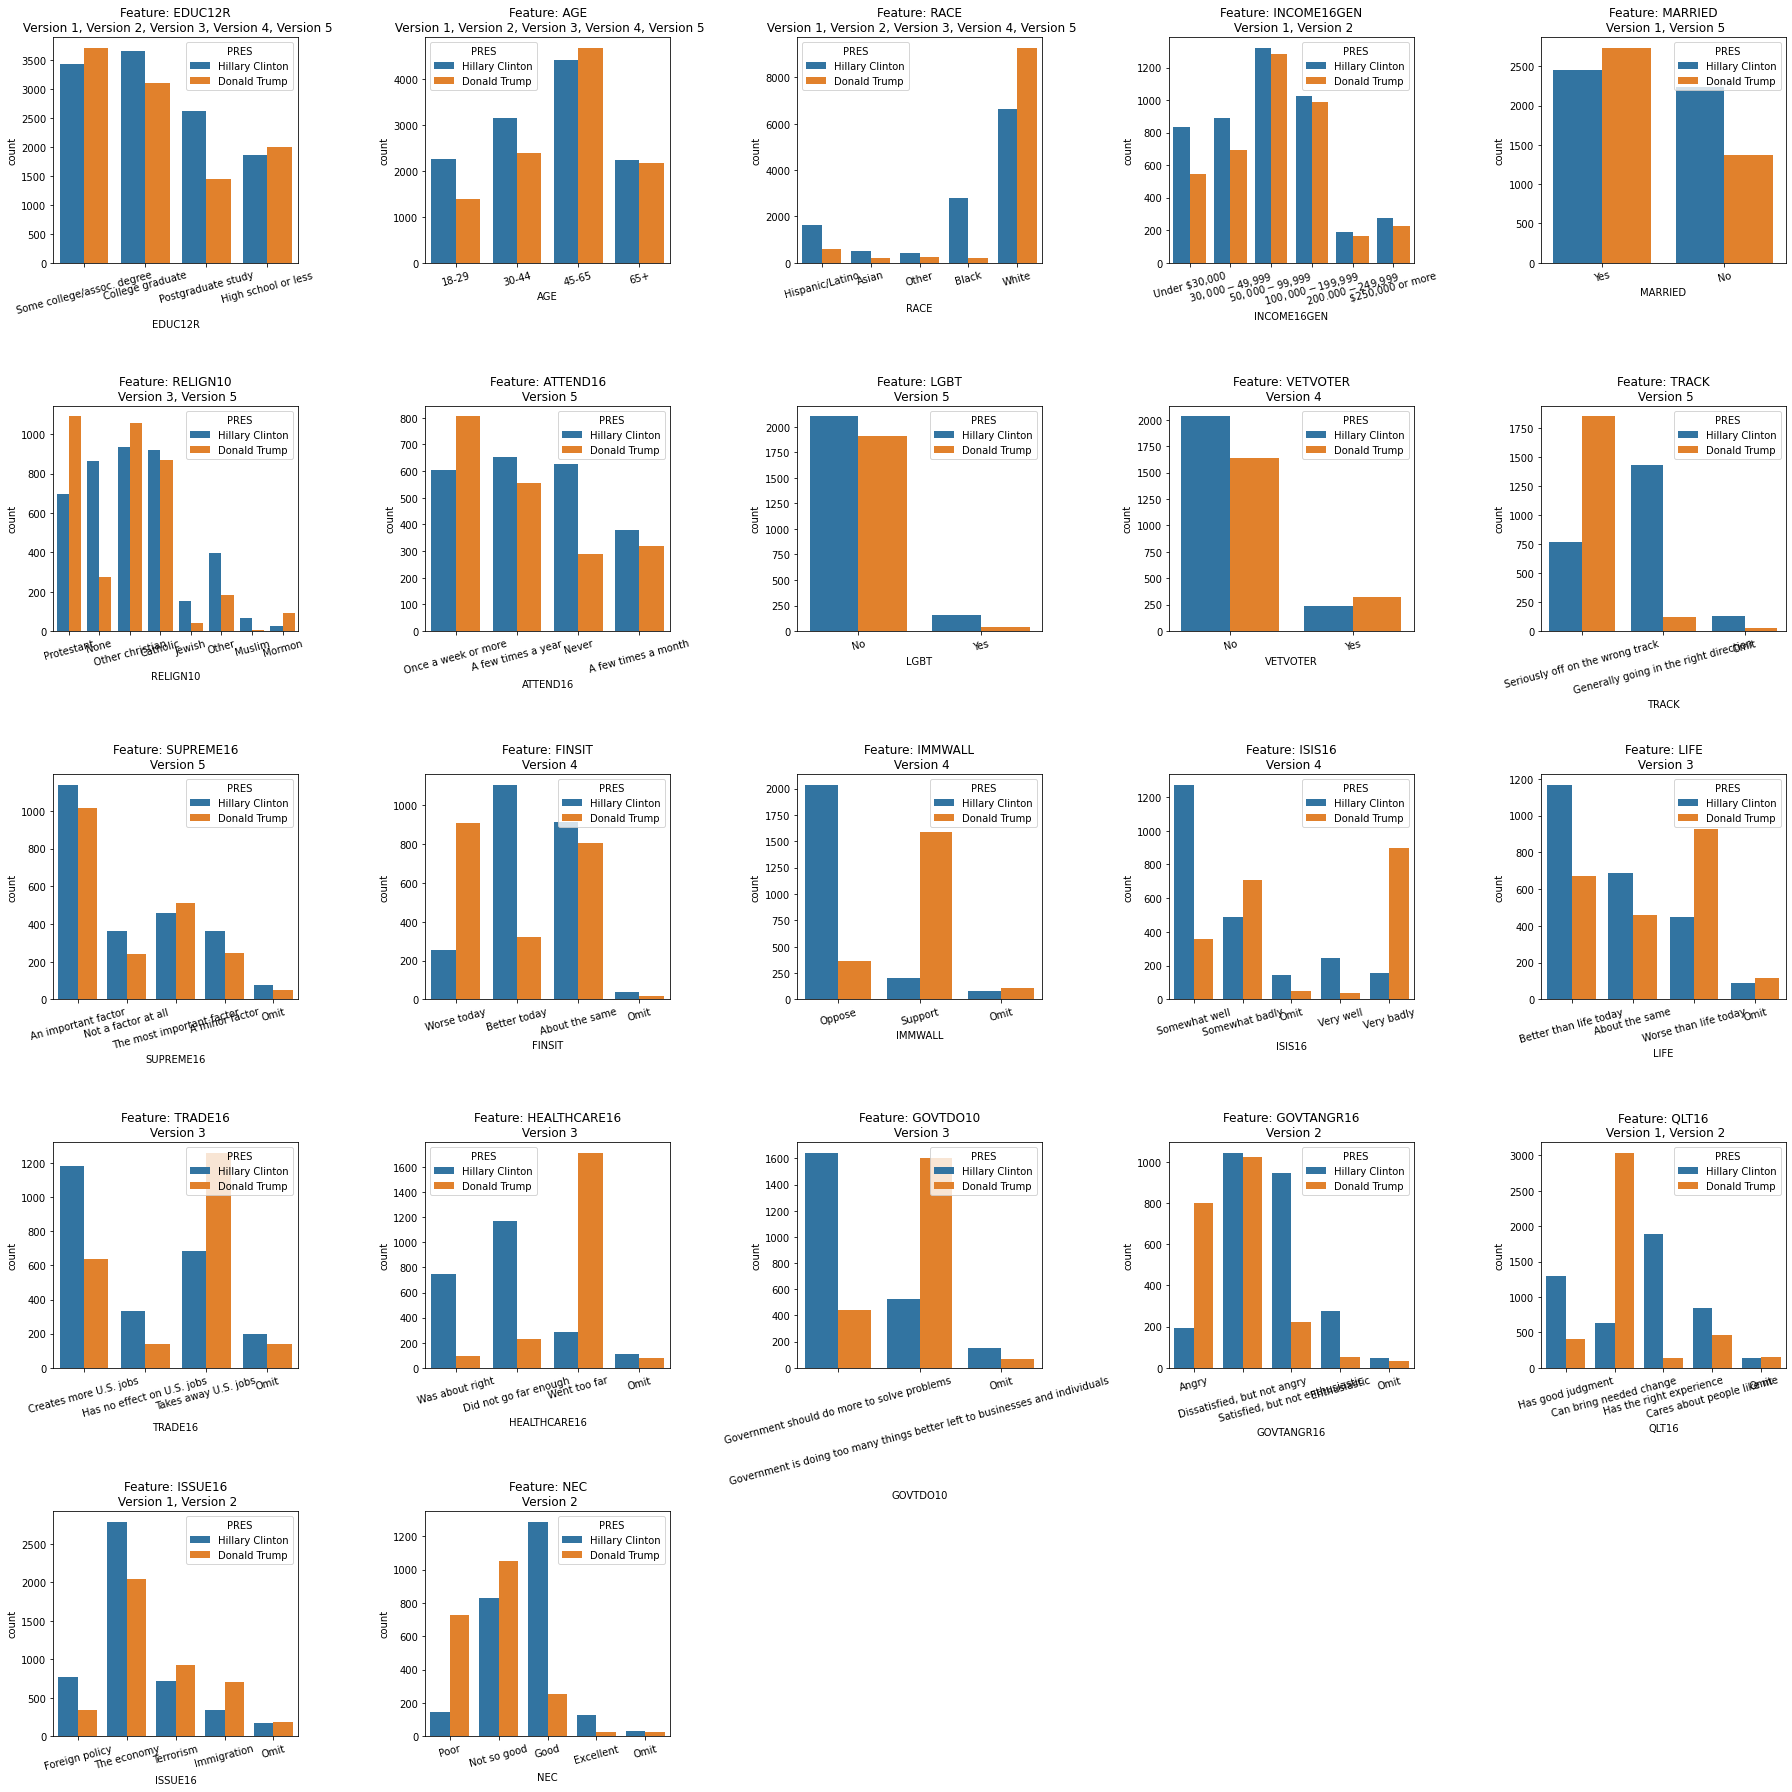

In [ ]:
fig = plt.figure(figsize=(25,25))
 
for idx, f in enumerate(features):
    ax = fig.add_subplot(5,5,idx+1)
    versions = df[[f, 'VERSION']].dropna()['VERSION'].unique()
    sns.countplot(data=df, x=f, hue='PRES', ax=ax)
    ax.set_title(f)
    plt.xticks(rotation=15)
    plt.title("Feature: %s\n %s" % (f, np.str.join(', ', versions)))
 
plt.tight_layout()
plt.show()

We can see that `HEALTHCARE16` is much more predictive of presidential vote than `SUPREME16` (for example).

But, the $k$ nearest neighbors algorithm treats all features as if they are equally important.

We may get better results if we exclude certain features from our analysis, rather than using all features (as we have above). Also, the distance computations will be faster with a smaller number of features.

How should we select the features to include in our model?

There are a few general approaches to feature selection:

* **Wrapper methods** use the ML model on the data, and  select relevant features based the model performance. (For example, we might train a linear regression on different combinations of features, and the then select the one that has the best performance on a validation set.)
* **Filter methods** use statistical characteristics of the data to select the features that are more useful for predicting the target variable. (For example, we might select the features that have the highest correlation with the target variable.)
* **Embedded methods** do feature selection "automatically" as part of the model training. (LASSO is an example of this type of feature selection.)

We also need to decide whether we want to take the dependencies between features into account, or not.

With **univariate feature selection**, we consider each feature independently. For example, we might score each feature according to its correlation with the target variable, then pick the features with the highest scores. 

The problem with univariate feature selection is that some features may carry redundant information. In that case, we don't gain much from having both features in our model, but both will have similar scores.

As an alternative to univariate feature selection, we might consider **greedy feature selection**:

* Let $S^{t-1}$ be the set of selected features at time ${t-1}$.
* Compute the score for all combinations of the current set of features + one more feature
* For the next time step $S^t$, add the feature that gave you the best score.

In the following example, we are going to use a **filter method** and **univariate feature selection**, because these are cheaper.

We have one last decision to make: what statistic to use to score our features? In the example below, we use mutual information to rank the features.

In [ ]:
cols = df_combined_nan.drop('PRES', axis=1).columns
cols

Index(['EDUC12R', 'AGE', 'INCOME16GEN', 'ATTEND16', 'SUPREME16', 'ISIS16',
       'LIFE', 'GOVTANGR16', 'NEC', 'HEALTHCARE16', 'FINSIT', 'TRADE16', 'SEX',
       'MARRIED', 'LGBT', 'TRACK', 'VETVOTER', 'IMMWALL', 'GOVTDO10',
       'RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black',
       'RACE_White', 'ISSUE16_Foreign policy', 'ISSUE16_The economy',
       'ISSUE16_Terrorism', 'ISSUE16_Immigration', 'QLT16_Has good judgment',
       'QLT16_Can bring needed change', 'QLT16_Has the right experience',
       'QLT16_Cares about people like me', 'RELIGN10_Protestant',
       'RELIGN10_None', 'RELIGN10_Other christian', 'RELIGN10_Catholic',
       'RELIGN10_Jewish', 'RELIGN10_Other', 'RELIGN10_Muslim',
       'RELIGN10_Mormon'],
      dtype='object')

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
col_weights = np.zeros(df_combined_nan.drop('PRES', axis=1).shape[1])
for idx, c in enumerate(cols):
  df_col = pd.concat([X_train[c], y_train], axis=1).dropna()
  col_weights[idx] = mutual_info_classif(np.array(df_col[c]).reshape(-1,1), df_col['PRES'], discrete_features=True, n_neighbors=51)[0]

In [ ]:
cols[np.argsort(col_weights)]

Index(['RELIGN10_Catholic', 'RACE_Other', 'RELIGN10_Other christian',
       'INCOME16GEN', 'RACE_Asian', 'RELIGN10_Other', 'RELIGN10_Muslim',
       'VETVOTER', 'RELIGN10_Mormon', 'SUPREME16', 'ISSUE16_Terrorism',
       'QLT16_Cares about people like me', 'ISSUE16_The economy',
       'RELIGN10_Jewish', 'AGE', 'ISSUE16_Foreign policy', 'EDUC12R', 'LGBT',
       'SEX', 'RACE_Hispanic/Latino', 'MARRIED', 'RELIGN10_Protestant',
       'ISSUE16_Immigration', 'ATTEND16', 'RELIGN10_None',
       'QLT16_Has good judgment', 'LIFE', 'TRADE16', 'RACE_Black',
       'RACE_White', 'FINSIT', 'QLT16_Has the right experience', 'GOVTANGR16',
       'NEC', 'GOVTDO10', 'ISIS16', 'QLT16_Can bring needed change', 'TRACK',
       'HEALTHCARE16', 'IMMWALL'],
      dtype='object')

Now let's choose the "best" number of features by CV.
 
(This will take a while, so start it running, then walk away and come back in a couple of hours.)

In [ ]:
from sklearn.model_selection import KFold

n_fold = 5
nfeature_list = np.arange(10, len(cols), 1)
n_f = len(nfeature_list)
acc_feature_list = np.zeros((n_f, n_fold))

distances_feature_selection = np.zeros(shape=(X_train.shape[0], X_train.shape[0]))

kf = KFold(n_splits=n_fold)
kf.get_n_splits(X_train)

for idx_n, n in tqdm(enumerate(nfeature_list), total=n_f, desc="N features"):
  
  keep_columns = cols[np.argsort(col_weights)[-n:]]

  for idx_train in range(X_train.shape[0]):
    distances_feature_selection[idx_train] = custom_distance(X_train[keep_columns].iloc[idx_train], X_train[keep_columns])

  for isplit, idx in enumerate(kf.split(X_train)):

    train_index, val_index = idx 

    y_train_kfold = y_train.iloc[train_index]
    y_val_kfold = y_train.iloc[val_index]

    y_train_kfold.reset_index(drop=True, inplace=True)
    y_val_kfold.reset_index(drop=True, inplace=True)

    distances_val_kfold = distances_feature_selection[val_index[:, None], train_index]

    y_pred = [y_train_kfold.loc[np.argsort(dist)[:k_opt]].mode()[0] for dist in distances_val_kfold]
    acc_feature_list[idx_n, isplit] = accuracy_score(np.array(y_val_kfold), np.array(y_pred))

N features:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
N features: 100%|██████████| 30/30 [1:28:27<00:00, 176.92s/it]


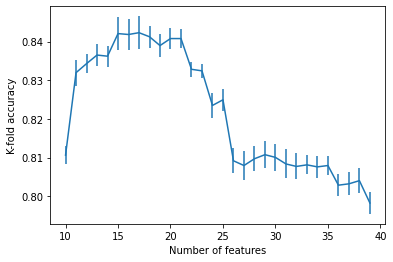

In [ ]:
plt.errorbar(x=nfeature_list, y=acc_feature_list.mean(axis=1), yerr=acc_feature_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("Number of features");
plt.ylabel("K-fold accuracy");

In [ ]:
n_opt=nfeature_list[np.argmax(acc_feature_list.mean(axis=1))]
print(n_opt)

17


According to the K-fold CV, these are the features we should use to fit our model:

In [ ]:
keep_columns = cols[np.argsort(col_weights)[-n_opt:]]
keep_columns

Index(['ATTEND16', 'RELIGN10_None', 'QLT16_Has good judgment', 'LIFE',
       'TRADE16', 'RACE_Black', 'RACE_White', 'FINSIT',
       'QLT16_Has the right experience', 'GOVTANGR16', 'NEC', 'GOVTDO10',
       'ISIS16', 'QLT16_Can bring needed change', 'TRACK', 'HEALTHCARE16',
       'IMMWALL'],
      dtype='object')

We can re-fit our model using only those features, and then evaluate it on the test set:

In [ ]:
distances_feature_selection = np.zeros(shape=(X_test.shape[0], X_train.shape[0]))
for idx_test in range(X_test.shape[0]):
  distances_feature_selection[idx_test] = custom_distance(X_test[keep_columns].iloc[idx_test], X_train[keep_columns])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [ ]:
y_pred = np.array([y_train.loc[np.argsort(dist)[:k_opt]].mode() for dist in distances_feature_selection]).ravel()

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

0.8447368421052631

### Bonus: Use feature weights

As an alternative to feature selection, where we completely disregard some features, we can potentially improve performance by using all features but *weighting* them.



The features that are more informative regarding the target variable will be weighted more heavily than those that are not so informative.

This has the advantage of not throwing out useful information; on the other hand, we don't get the benefit of faster computation, as we did with feature selection.

We can use the mutual information statistic we computed earlier to weight our columns:

In [ ]:
X_train_weighted = X_train.multiply(col_weights)
X_test_weighted = X_test.multiply(col_weights)

In [ ]:
X_train_weighted.describe()

,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16,SEX,MARRIED,LGBT,TRACK,VETVOTER,IMMWALL,GOVTDO10,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon
count,16337.000000,16979.000000,6302.000000,3193.000000,3272.000000,3129.000000,3264.000000,3407.000000,3326.000000,3169.000000,3235.000000,3180.000000,17064.000000,6600.000000,3169.000000,3138.000000,3177.000000,3146.000000,3156.000000,16863.000000,16863.000000,16863.000000,16863.000000,16863.000000,6719.000000,6719.000000,6719.000000,6719.000000,6719.000000,6719.000000,6719.000000,6719.000000,5773.000000,5773.000000,5773.000000,5773.000000,5773.000000,5773.000000,5773.000000,5773.000000
mean,0.003767,0.002929,0.001029,0.008899,0.002416,0.067303,0.022514,0.043053,0.081739,0.116825,0.051639,0.023750,0.003939,0.006001,0.000374,0.077795,0.000497,0.127473,0.073955,0.000868,0.000081,0.000010,0.007900,0.048425,0.000879,0.002593,0.000791,0.001423,0.004788,0.079287,0.024153,0.000626,0.002681,0.002881,0.000545,0.000073,0.000128,0.000268,0.000034,0.000055
std,0.002469,0.001741,0.000692,0.006328,0.001274,0.048473,0.017296,0.031442,0.036569,0.121644,0.037419,0.023416,0.004368,0.004979,0.001689,0.100092,0.001284,0.147531,0.075578,0.002640,0.000459,0.000057,0.020207,0.031002,0.002328,0.002420,0.001661,0.003909,0.009913,0.095055,0.045057,0.001530,0.004842,0.006963,0.000916,0.000134,0.000781,0.000919,0.000351,0.000462
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002503,0.001795,0.000520,0.005501,0.001346,0.000000,0.000000,0.036735,0.045908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.002503,0.003590,0.001040,0.005501,0.002693,0.052846,0.020339,0.036735,0.091815,0.138039,0.048689,0.024869,0.000000,0.010131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068271,0.000000,0.004852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.005006,0.003590,0.001560,0.016503,0.002693,0.105691,0.040678,0.073470,0.091815,0.276077,0.097377,0.049737,0.008782,0.010131,0.000000,0.206533,0.000000,0.298164,0.151166,0.000000,0.000000,0.000000,0.000000,0.068271,0.000000,0.004852,0.000000,0.000000,0.000000,0.193228,0.000000,0.000000,0.000000,0.000000,0.002085,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.007509,0.005385,0.002601,0.016503,0.004039,0.158537,0.040678,0.110204,0.137723,0.276077,0.097377,0.049737,0.008782,0.010131,0.008001,0.206533,0.003812,0.298164,0.151166,0.008896,0.002688,0.000332,0.059582,0.068271,0.007041,0.004852,0.004281,0.012160,0.025311,0.193228,0.108191,0.004361,0.011423,0.019708,0.002085,0.000318,0.004892,0.003422,0.003644,0.003906


Now, we'll re-compute distances for the weighted columns (using *all* columns):

In [ ]:
distances_custom_weighted = np.zeros(shape=(X_test_weighted.shape[0], X_train_weighted.shape[0]))
distances_custom_weighted.shape

(5700, 17098)

In [ ]:
for idx in tqdm(range(X_test_weighted.shape[0]), total=X_test_weighted.shape[0], desc="Test samples"):
  distances_custom_weighted[idx] = custom_distance(X_test_weighted.iloc[idx], X_train_weighted)

Test samples:   0%|          | 0/5700 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
Test samples: 100%|██████████| 5700/5700 [00:48<00:00, 118.46it/s]


And evaluate the model performance on the test set:

In [ ]:
y_pred = [y_train.loc[np.argsort(dist)[:k_opt]].mode() for dist in distances_custom_weighted]

In [ ]:
acc = accuracy_score(y_pred, y_test)
acc

0.8580701754385965